Column definitions (from project challenge description)

    DATOP - Date of flight
    FLTID - Flight number
    DEPSTN - Departure point
    ARRSTN - Arrival point
    STD - Scheduled Time departure
    STA - Scheduled Time arrival
    STATUS - Flight status
    ETD - Expected Time departure
    ETA - Expected Time arrival
    ATD - Actual Time of Departure
    ATA - Actual Time of arrival
    DELAY1 - Delay code 1
    DUR1 - delay time 1
    DELAY2 - Delay code 2
    DUR2 - delay time 2
    DELAY3 - Delay code 3
    DUR3 - delay time 3
    DELAY4 - Delay code 4
    DUR4 - delay time 4
    AC - Aircraft Code


In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import pickle

#import supporting functions used for cleaning
from supporting_functions import prediction_plot, make_combined_prediction

In [2]:
# load data (cleaned with preprocess_data.ipynb)
with open('data/clean_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

X_train            = loaded_data[0]
X_test             = loaded_data[1]
y_train            = loaded_data[2]
y_test             = loaded_data[3]
discarded_features = loaded_data[4]
scaler             = loaded_data[5]

In [3]:
# load classification model
with open('models/xgboost_classifier.pkl', 'rb') as f:
    Grid_search = pickle.load(f)
classification_model = Grid_search.best_estimator_

In [4]:
# load regression model
with open('models/xgboost_regression.pkl', 'rb') as f:
    Grid_search = pickle.load(f)
regression_model = Grid_search.best_estimator_

## Calculate and evaluate very simplistic (baseline) model that just predicts a constant (the average) for all delays

Train Mean Squared Error: 16023.881616180359
test Mean Squared Error: 16410.29582232114


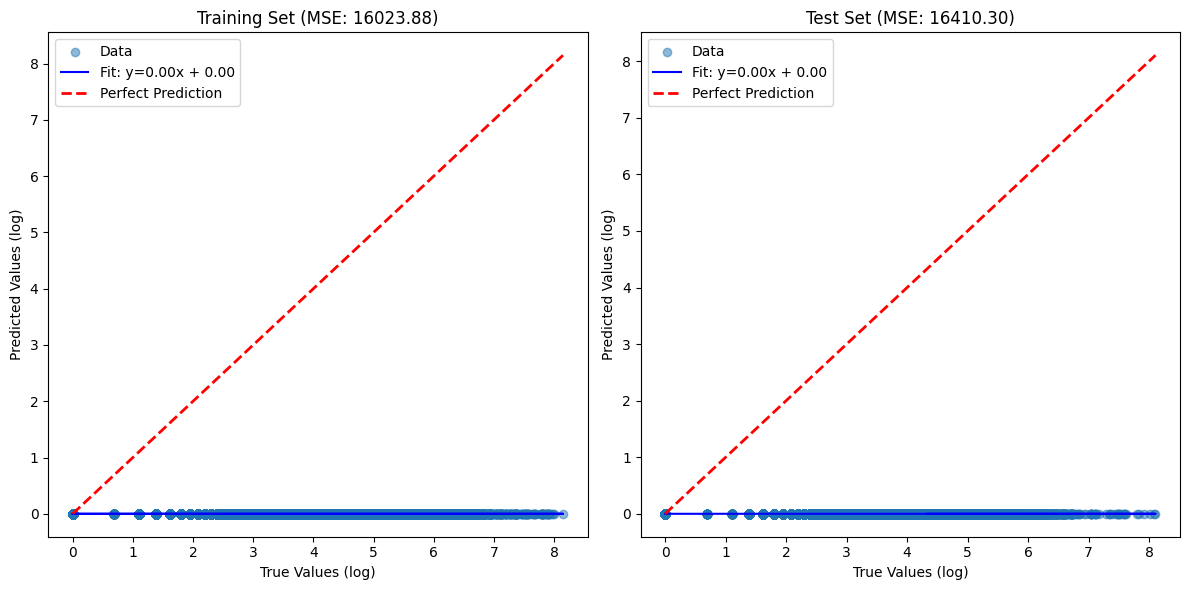

In [5]:
y_pred_train = np.zeros(np.shape(y_train)) + np.log1p(np.mean(np.expm1(y_train)))
y_pred       = np.zeros(np.shape(y_test))  + np.log1p(np.mean(np.expm1(y_train)))

train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))
test_mse  = mean_squared_error(np.expm1(y_test),  np.expm1(y_pred))

print("Train Mean Squared Error:", train_mse)
print("test Mean Squared Error:",  test_mse)

prediction_plot(y_test,y_pred)
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
plt.title(f'Test Set (MSE: {test_mse:.2f})')

## Make prediction using the combined models

In [6]:
y_pred_train = make_combined_prediction(X_train,classification_model,regression_model)
y_pred       = make_combined_prediction(X_test, classification_model,regression_model)

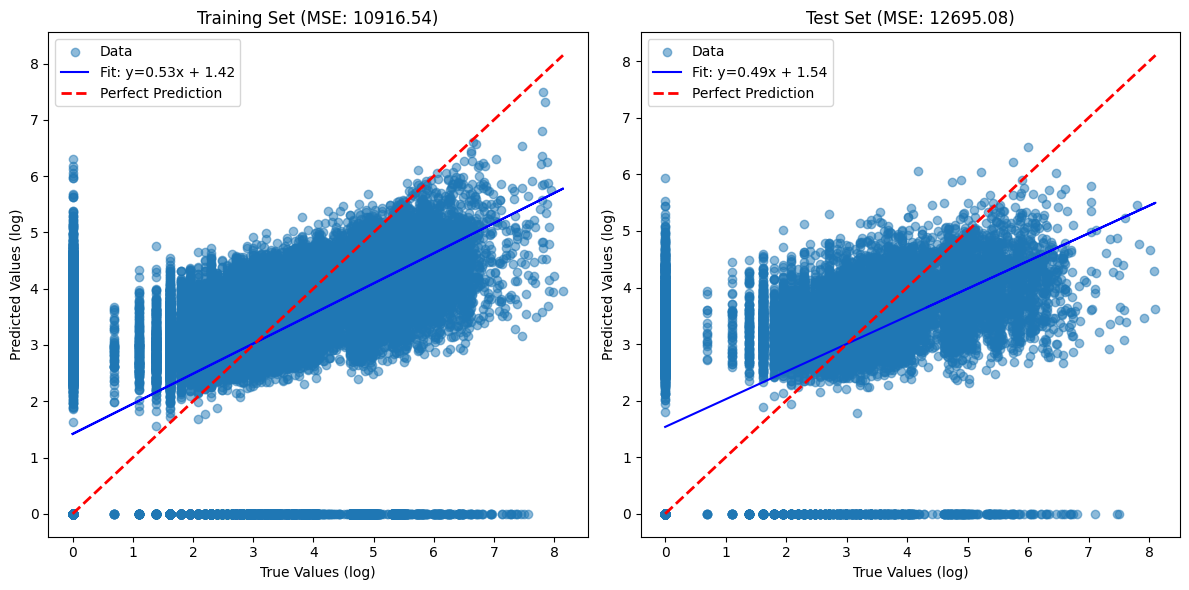

Train Mean Squared Error: 10916.541738182494
test Mean Squared Error: 12695.08332174155


In [7]:


train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))
test_mse  = mean_squared_error(np.expm1(y_test),  np.expm1(y_pred))

print("Train Mean Squared Error:", train_mse)
print("test Mean Squared Error:",  test_mse)

prediction_plot(y_test,y_pred)
plt.title(f'Test Set (MSE: {test_mse:.2f})')
plt.savefig('./plots/Combined_prediction_plot.png', bbox_inches='tight',transparent=True)

In [8]:
X_train.columns



# ETD - Expected Time departure
# ETA - Expected Time arrival
# ATD - Actual Time of Departure
# ATA - Actual Time of arrival
# DELAY1 - Delay code 1
# DUR1 - delay time 1
# DELAY2 - Delay code 2
# DUR2 - delay time 2
# DELAY3 - Delay code 3
# DUR3 - delay time 3
# DELAY4 - Delay code 4
# DUR4 - delay time 4
# AC - Aircraft Code



Index(['year', 'month', 'day', 'flight_time', 'std_hour', 'sta_hour',
       'arrstn_abj', 'arrstn_adb', 'arrstn_ahu', 'arrstn_alg',
       ...
       'flight_code_d4', 'flight_code_dat', 'flight_code_gjt',
       'flight_code_int', 'flight_code_pro', 'flight_code_sgt',
       'flight_code_tu', 'flight_code_ug', 'flight_code_uh',
       'flight_code_wkl'],
      dtype='object', length=350)

In [9]:
X = X_train.copy()


In [10]:
[col for col in X if col.startswith('status')]

['status_del', 'status_dep', 'status_rtr', 'status_sch']

In [11]:
#define dictionary of features to collapse across when computing feature importance
feature_dict = {'Date':                 ['year', 'month', 'day'],
                'Flight code':          [col for col in X if col.startswith('flight_code')],
                'Departure location':   [col for col in X if col.startswith('depstn')],
                'Arrival location':     [col for col in X if col.startswith('arrstn')],
                'Flight status':        [col for col in X if col.startswith('status')],
                'Flight time':          ['flight_time'],
                'Aircraft code':        [col for col in X if col.startswith('ac_')],
} 

In [12]:
from supporting_functions import compute_condensed_feature_importance

npermutes = 10
metric    = mean_squared_error

#calculate feature importance
feature_importance, feature_labels = compute_condensed_feature_importance(X_test, y_test, feature_dict, classification_model, regression_model, metric, npermutes)

base metric = 12695.08332174155
permutaiton 1 / 10
permutaiton 2 / 10
permutaiton 3 / 10
permutaiton 4 / 10
permutaiton 5 / 10
permutaiton 6 / 10
permutaiton 7 / 10
permutaiton 8 / 10
permutaiton 9 / 10
permutaiton 10 / 10


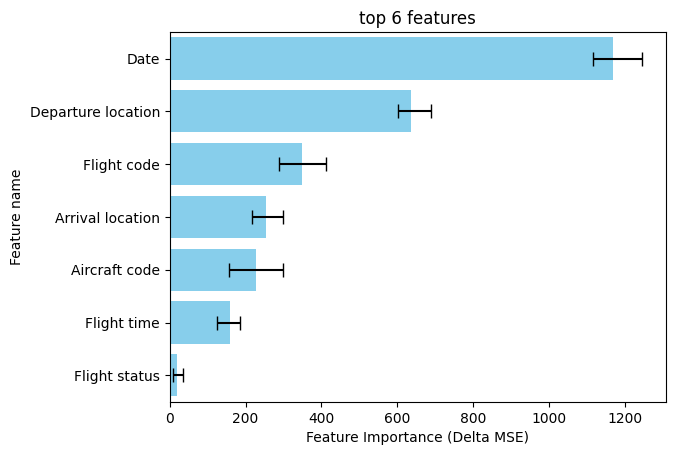

In [13]:
from supporting_functions import feature_importance_plot

N = 6 #how many features do we want to show in the plot
feature_importance_plot(feature_importance,feature_labels,N)